In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, QuantileTransformer


class SmartNormalizer:
    def __init__(self, two_col=False):
        self.quantile_transformer = None
        self.encoder = None
        self.two_col = two_col
        self.is_numeric = None

    def fit(self, data):
        assert type(data) == np.ndarray
        data = data.copy().ravel()
        self.is_numeric = data.dtype != np.dtype("O")
        if self.is_numeric:
            good_mask = np.isfinite(data)
            data = data[good_mask]
            if not len(data):
                data = np.zeros(1)
            data = data.reshape(-1, 1)
            self.quantile_transformer = QuantileTransformer(
                output_distribution="normal", n_quantiles=min(100, len(data))
            )
            self.quantile_transformer.fit(data)
        else:
            data = data.reshape(-1, 1)
            self.encoder = OrdinalEncoder(
                handle_unknown="use_encoded_value",
                unknown_value=-1,
            )
            self.encoder.fit(data)

    def transform(self, data):
        data = data.copy().ravel()
        if self.is_numeric:
            good_mask = np.isfinite(data)
            data[~good_mask] = 0
            data = data.reshape(-1, 1)
            first_col = self.quantile_transformer.transform(data)
        else:
            good_mask = data != None
            data = data.reshape(-1, 1)
            first_col = self.encoder.transform(data)
        if self.two_col:
            second_col = good_mask.astype(np.float32).reshape(-1, 1)
            return np.concatenate([first_col, second_col], axis=1)
        else:
            return first_col.reshape(-1, 1)


class SmartNormalizerDF:
    def __init__(self, two_col=False):
        self.two_col = two_col
        self.normalizers = {}

    def fit(self, df):
        for col in df.columns:
            self.normalizers[col] = SmartNormalizer(self.two_col)
            self.normalizers[col].fit(df[col].values)

    def transform(self, df):
        df = df.copy()
        for i, col in enumerate(df.columns):
            if self.two_col:
                df[[col, col + "_ok"]] = self.normalizers[col].transform(df[col].values)
            else:
                df[col] = self.normalizers[col].transform(df[col].values)
            if i % 10 == 0:
                df = df.copy()
        return df


In [60]:
target_col = "label"  # "status"
ok_val = 1  # "OK"
important_columns = [
    "s8_sensor100_millimeter_step1",
    "shift",
    "weekday",
    "s4_sensor16_minuten (zeit)_step1",
    "s5_sensor0_sekunden (zeit)_step1",
    "s10_sensor2_gramm_step1",
    "s3_sensor0_km_step1",
    "s7_sensor26_mikroohm_step1",
    "s8_sensor32_millimeter_step1",
    "s10_sensor0_minuten (zeit)_step1",
    "temperature_2m",
    "relative_humidity_2m",
    "precipitation",
    "pressure_msl",
]


In [61]:
def add_weather_data(df):
    weather_df = pd.read_csv("weather.csv")
    weather_df = weather_df.rename(columns={"date": "message_timestamp"})
    # round message_timestamp to nearest hour, remove timezone from both
    weather_df["message_timestamp"] = weather_df["message_timestamp"].apply(
        lambda x: pd.Timestamp(x).tz_localize(None).round("h")
    )
    df["message_timestamp"] = df["message_timestamp"].apply(
        lambda x: pd.Timestamp(x).tz_localize(None).round("h")
    )
    df = df.merge(weather_df, on="message_timestamp", how="inner")
    return df


In [62]:
df = pd.read_csv("train.csv")
df = add_weather_data(df).drop(columns=["message_timestamp", "physical_part_id"])
target = df[target_col] == ok_val
df = df.drop(columns=[target_col])
df = df[important_columns]
df_train = df.sample(frac=0.8)
df_valid = df.drop(df_train.index)

smart_normalizer = SmartNormalizerDF(two_col=True)
smart_normalizer.fit(df_train)
df_train = smart_normalizer.transform(df_train)
target_train = target[df_train.index]
df_valid = smart_normalizer.transform(df_valid)
target_valid = target[df_valid.index]


In [63]:
print(target_train.mean(), target_valid.mean())
print(target_train.shape, target_valid.shape)


0.9500759242616753 0.9459526465848519
(32269,) (8067,)


In [72]:
from catboost import CatBoostClassifier

model = CatBoostClassifier()
model.fit(df_train, target_train, eval_set=(df_valid, target_valid), verbose=10)


Learning rate set to 0.074744
0:	learn: 0.5947937	test: 0.5961499	best: 0.5961499 (0)	total: 7.51ms	remaining: 7.5s
10:	learn: 0.2321391	test: 0.2390389	best: 0.2390389 (10)	total: 49ms	remaining: 4.41s
20:	learn: 0.1746115	test: 0.1808548	best: 0.1808548 (20)	total: 87.5ms	remaining: 4.08s
30:	learn: 0.1597758	test: 0.1656701	best: 0.1656701 (30)	total: 124ms	remaining: 3.87s
40:	learn: 0.1535034	test: 0.1598536	best: 0.1598536 (40)	total: 161ms	remaining: 3.77s
50:	learn: 0.1493202	test: 0.1561547	best: 0.1561547 (50)	total: 202ms	remaining: 3.75s
60:	learn: 0.1466040	test: 0.1543390	best: 0.1543390 (60)	total: 238ms	remaining: 3.67s
70:	learn: 0.1444804	test: 0.1531845	best: 0.1531845 (70)	total: 276ms	remaining: 3.61s
80:	learn: 0.1431430	test: 0.1528604	best: 0.1528236 (78)	total: 310ms	remaining: 3.52s
90:	learn: 0.1416329	test: 0.1523980	best: 0.1523980 (90)	total: 348ms	remaining: 3.47s
100:	learn: 0.1404707	test: 0.1519934	best: 0.1519934 (100)	total: 383ms	remaining: 3.4s
110

In [73]:
# Show feature importance
importances = model.get_feature_importance()
feature_names = model.feature_names_
sorted_idx = importances.argsort()[::-1]
all_results = [
    (feature_names[sorted_idx[i]], importances[sorted_idx[i]])
    for i in range(len(feature_names))
    # if "_ok" in feature_names[sorted_idx[i]]
]
# for name, imp in all_results[:30]:
#     print(f"{name}: {imp}")

top_features = [name for name, imp in all_results[:10]]
print(top_features)


['temperature_2m', 'pressure_msl', 'relative_humidity_2m', 'weekday', 's10_sensor2_gramm_step1', 'shift', 's5_sensor0_sekunden (zeit)_step1', 's8_sensor32_millimeter_step1', 's8_sensor100_millimeter_step1', 's7_sensor26_mikroohm_step1']


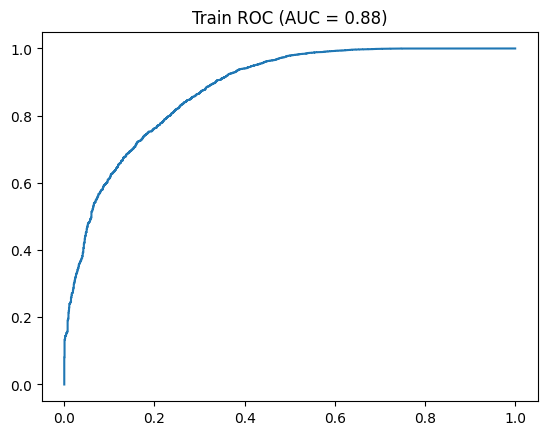

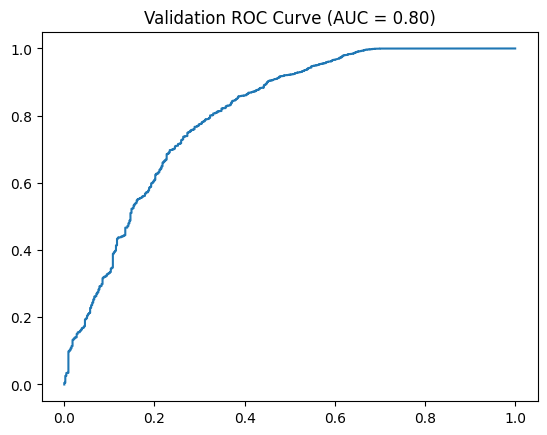

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

y_pred = model.predict_proba(df_train)[:, 1]
fpr, tpr, thresholds = roc_curve(target_train, y_pred)
roc_auc = auc(fpr, tpr)
plt.title(f"Train ROC (AUC = {roc_auc:.2f})")
plt.plot(fpr, tpr)
plt.show()

y_pred = model.predict_proba(df_valid)[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, y_pred)
roc_auc = auc(fpr, tpr)
plt.title(f"Validation ROC Curve (AUC = {roc_auc:.2f})")
plt.plot(fpr, tpr)
plt.show()


In [77]:
test_df = pd.read_csv("test.csv")
test_df = add_weather_data(test_df).drop(
    columns=["message_timestamp", "physical_part_id"]
)
test_df = test_df[important_columns]
test_df = smart_normalizer.transform(test_df)
y_pred = model.predict_proba(test_df)[:, 1]
print(y_pred.shape)
print(y_pred[:10])


(4482,)
[0.96403337 0.98243899 0.96441066 0.98425425 0.98258085 0.92601225
 0.41799628 0.97964349 0.99027482 0.99035877]


In [78]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["label"] = y_pred
sample_submission.to_csv("submission.csv", index=False)


In [82]:
(sample_submission["label"] < 0.5).value_counts()


label
False    4420
True       62
Name: count, dtype: int64